# 라이브러리 추가

In [1]:
!pip install torchsummary
from copy import deepcopy
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary as summary_

from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드

In [2]:
train = datasets.MNIST(root="~/", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
test  = datasets.MNIST(root="~/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/MNIST/raw/train-images-idx3-ubyte.gz to /root/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/MNIST/raw/train-labels-idx1-ubyte.gz to /root/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/MNIST/raw



In [3]:
def generate_dataloader(batch_size=100) :
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataloader  = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)
    return train_dataloader, test_dataloader

train_dloader, test_dloader = generate_dataloader()

# 모델 구성

In [4]:
class CustomCNNModel1(nn.Module) :
    def __init__(self) :
        super(CustomCNNModel1, self).__init__()
        
        self.layer = nn.Sequential(
            # 32 * 28 * 28
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # 64 * 28 * 28
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # 64 * 14 * 14
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fcLayer = nn.Sequential(
            nn.Linear(14 * 14 * 64, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x) :
        output = self.layer(x)
        output = output.view(output.size(0), -1)
        output = self.fcLayer(output)
        output = F.log_softmax(output, dim=1)
        return output

class CustomCNNModel2(nn.Module) :
    def __init__(self) :
        super(CustomCNNModel2, self).__init__()
        
        self.layer = nn.Sequential(
            # 8 * 28 * 28
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # 16 * 28 * 28
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # 16 * 14 * 14
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 32 * 14 * 14
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # 64 * 14 * 14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # 64 * 7 * 7
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fcLayer = nn.Sequential(
            nn.Linear(7 * 7 * 64, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x) :
        output = self.layer(x)
        output = output.view(output.size(0), -1)
        output = self.fcLayer(output)
        output = F.log_softmax(output, dim=1)
        return output

class CustomCNNModel3(nn.Module) :
    def __init__(self) :
        super(CustomCNNModel3, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.residual_block = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.mpLayer = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.relu    = nn.ReLU()

        self.fcLayer = nn.Sequential(
            nn.Linear(14 * 14 * 32, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x) :
        # 32 * 28 * 28
        output = self.layer(x)
        
        # 32 * 28 * 28
        first_residual_block_input = output
        output = self.residual_block(output)
        output = output + first_residual_block_input
        output = self.relu(output)

        # 32 * 28 * 28
        second_residual_block_input = output
        output = self.residual_block(output)
        output = output + second_residual_block_input
        output = self.relu(output)

        # 32 * 14 * 14
        output = self.mpLayer(output)

        output = output.view(output.size(0), -1)
        output = self.fcLayer(output)
        output = F.log_softmax(output, dim=1)
        return output

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
model1 = CustomCNNModel1().to(device)
model2 = CustomCNNModel2().to(device)
model3 = CustomCNNModel3().to(device)

# Cost 함수 및 Optimizer 셋팅

In [7]:
loss_func1 = nn.NLLLoss()
optimizer1 = optim.Adam(model1.parameters())

loss_func2 = nn.NLLLoss()
optimizer2 = optim.Adam(model2.parameters())

loss_func3 = nn.NLLLoss()
optimizer3 = optim.Adam(model3.parameters())

# 모델 Layer Summary

## Model1

In [8]:
summary_(model1, (1, 28, 28), batch_size=100)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [100, 32, 28, 28]             320
              ReLU-2          [100, 32, 28, 28]               0
            Conv2d-3          [100, 64, 28, 28]          18,496
              ReLU-4          [100, 64, 28, 28]               0
         MaxPool2d-5          [100, 64, 14, 14]               0
            Linear-6                  [100, 64]         802,880
              ReLU-7                  [100, 64]               0
            Linear-8                  [100, 10]             650
Total params: 822,346
Trainable params: 822,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.30
Forward/backward pass size (MB): 124.52
Params size (MB): 3.14
Estimated Total Size (MB): 127.96
----------------------------------------------------------------


## Model2

In [9]:
summary_(model2, (1, 28, 28), batch_size=100)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [100, 8, 28, 28]              80
              ReLU-2           [100, 8, 28, 28]               0
            Conv2d-3          [100, 16, 28, 28]           1,168
              ReLU-4          [100, 16, 28, 28]               0
         MaxPool2d-5          [100, 16, 14, 14]               0
            Conv2d-6          [100, 32, 14, 14]           4,640
              ReLU-7          [100, 32, 14, 14]               0
            Conv2d-8          [100, 64, 14, 14]          18,496
              ReLU-9          [100, 64, 14, 14]               0
        MaxPool2d-10            [100, 64, 7, 7]               0
           Linear-11                  [100, 64]         200,768
             ReLU-12                  [100, 64]               0
           Linear-13                  [100, 10]             650
Total params: 225,802
Trainable params:

## Model3

In [10]:
summary_(model3, (1, 28, 28), batch_size=100)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [100, 32, 28, 28]             320
              ReLU-2          [100, 32, 28, 28]               0
            Conv2d-3          [100, 32, 28, 28]           9,248
              ReLU-4          [100, 32, 28, 28]               0
            Conv2d-5          [100, 32, 28, 28]           9,248
              ReLU-6          [100, 32, 28, 28]               0
            Conv2d-7          [100, 32, 28, 28]           9,248
              ReLU-8          [100, 32, 28, 28]               0
            Conv2d-9          [100, 32, 28, 28]           9,248
             ReLU-10          [100, 32, 28, 28]               0
        MaxPool2d-11          [100, 32, 14, 14]               0
           Linear-12                  [100, 64]         401,472
             ReLU-13                  [100, 64]               0
           Linear-14                  [

# Model Training & Test Part

## Model1 Training & Test

In [11]:
model1_cost = []
model1_acc = []

best_acc1 = 0.0
best_model1 = deepcopy(model1.state_dict())

for epoch in range(30) :
    avg_cost = 0

    model1.train()
    for x, y in train_dloader :
        x = x.to(device)
        y = y.to(device)

        optimizer1.zero_grad()
        output = model1(x)

        loss = loss_func1(output, y)
        loss.backward()
        optimizer1.step()

        avg_cost += loss.item()
    
    model1.eval()
    correct = 0
    with torch.no_grad() :
        for x, y in test_dloader :
            x = x.to(device)
            y = y.to(device)
            output = model1(x)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
    
    acc =  float(correct) / len(test_dloader.dataset)
    
    model1_cost.append(avg_cost / 600)
    model1_acc.append(acc)

    if acc * 100.0 > best_acc1 :
        best_acc1 = acc * 100.0
        best_model1 = deepcopy(model1.state_dict())
        
    print('Model1 => [Epoch: {:>4}] loss : {:>.7f} val_accuracy : {}/{} ({:>.4f}%)'.format(epoch + 1, avg_cost / 600, correct, len(test_dloader.dataset), acc * 100.))

Model1 => [Epoch:    1] loss : 0.1957386 val_accuracy : 9705/10000 (97.0500%)
Model1 => [Epoch:    2] loss : 0.0519459 val_accuracy : 9847/10000 (98.4700%)
Model1 => [Epoch:    3] loss : 0.0343013 val_accuracy : 9857/10000 (98.5700%)
Model1 => [Epoch:    4] loss : 0.0226746 val_accuracy : 9886/10000 (98.8600%)
Model1 => [Epoch:    5] loss : 0.0181891 val_accuracy : 9881/10000 (98.8100%)
Model1 => [Epoch:    6] loss : 0.0132381 val_accuracy : 9891/10000 (98.9100%)
Model1 => [Epoch:    7] loss : 0.0098031 val_accuracy : 9880/10000 (98.8000%)
Model1 => [Epoch:    8] loss : 0.0087944 val_accuracy : 9872/10000 (98.7200%)
Model1 => [Epoch:    9] loss : 0.0085750 val_accuracy : 9880/10000 (98.8000%)
Model1 => [Epoch:   10] loss : 0.0072407 val_accuracy : 9898/10000 (98.9800%)
Model1 => [Epoch:   11] loss : 0.0052919 val_accuracy : 9880/10000 (98.8000%)
Model1 => [Epoch:   12] loss : 0.0070840 val_accuracy : 9892/10000 (98.9200%)
Model1 => [Epoch:   13] loss : 0.0028314 val_accuracy : 9879/100

## Model2 Training & Test

In [12]:
model2_cost = []
model2_acc = []

best_acc2 = 0.0
best_model2 = deepcopy(model2.state_dict())

for epoch in range(30) :
    avg_cost = 0

    model2.train()
    for x, y in train_dloader :
        x = x.to(device)
        y = y.to(device)

        optimizer2.zero_grad()
        output = model2(x)

        loss = loss_func2(output, y)
        loss.backward()
        optimizer2.step()

        avg_cost += loss.item()
    
    model2.eval()
    correct = 0
    with torch.no_grad() :
        for x, y in test_dloader :
            x = x.to(device)
            y = y.to(device)
            output = model2(x)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
    
    acc =  float(correct) / len(test_dloader.dataset)
    
    model2_cost.append(avg_cost / 600)
    model2_acc.append(acc)

    if acc * 100.0 > best_acc2 :
        best_acc2 = acc * 100.0
        best_model2 = deepcopy(model2.state_dict())
        
    print('Model2 => [Epoch: {:>4}] loss : {:>.7f} val_accuracy : {}/{} ({:>.4f}%)'.format(epoch + 1, avg_cost / 600, correct, len(test_dloader.dataset), acc * 100.))

Model2 => [Epoch:    1] loss : 0.2621770 val_accuracy : 9746/10000 (97.4600%)
Model2 => [Epoch:    2] loss : 0.0613189 val_accuracy : 9855/10000 (98.5500%)
Model2 => [Epoch:    3] loss : 0.0427620 val_accuracy : 9862/10000 (98.6200%)
Model2 => [Epoch:    4] loss : 0.0333637 val_accuracy : 9874/10000 (98.7400%)
Model2 => [Epoch:    5] loss : 0.0270129 val_accuracy : 9904/10000 (99.0400%)
Model2 => [Epoch:    6] loss : 0.0206307 val_accuracy : 9892/10000 (98.9200%)
Model2 => [Epoch:    7] loss : 0.0184824 val_accuracy : 9892/10000 (98.9200%)
Model2 => [Epoch:    8] loss : 0.0142288 val_accuracy : 9894/10000 (98.9400%)
Model2 => [Epoch:    9] loss : 0.0133103 val_accuracy : 9872/10000 (98.7200%)
Model2 => [Epoch:   10] loss : 0.0119203 val_accuracy : 9888/10000 (98.8800%)
Model2 => [Epoch:   11] loss : 0.0096021 val_accuracy : 9896/10000 (98.9600%)
Model2 => [Epoch:   12] loss : 0.0087252 val_accuracy : 9906/10000 (99.0600%)
Model2 => [Epoch:   13] loss : 0.0086089 val_accuracy : 9902/100

## Model3 Training & Test

In [13]:
model3_cost = []
model3_acc = []

best_acc3 = 0.0
best_model3 = deepcopy(model3.state_dict())

for epoch in range(30) :
    avg_cost = 0

    model3.train()
    for x, y in train_dloader :
        x = x.to(device)
        y = y.to(device)

        optimizer3.zero_grad()
        output = model3(x)

        loss = loss_func3(output, y)
        loss.backward()
        optimizer3.step()

        avg_cost += loss.item()

    model3.eval()
    correct = 0
    with torch.no_grad() :
        for x, y in test_dloader :
            x = x.to(device)
            y = y.to(device)
            output = model3(x)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
    
    acc =  float(correct) / len(test_dloader.dataset)

    model3_cost.append(avg_cost / 600)
    model3_acc.append(acc)

    if acc * 100.0 > best_acc3 :
        best_acc3 = acc * 100.0
        best_model3 = deepcopy(model3.state_dict())

    print('Model3 => [Epoch: {:>4}] loss : {:>.7f} val_accuracy : {}/{} ({:>.4f}%)'.format(epoch + 1, avg_cost / 600, correct, len(test_dloader.dataset), acc * 100.))

Model3 => [Epoch:    1] loss : 0.1932156 val_accuracy : 9808/10000 (98.0800%)
Model3 => [Epoch:    2] loss : 0.0518336 val_accuracy : 9858/10000 (98.5800%)
Model3 => [Epoch:    3] loss : 0.0366882 val_accuracy : 9895/10000 (98.9500%)
Model3 => [Epoch:    4] loss : 0.0274982 val_accuracy : 9897/10000 (98.9700%)
Model3 => [Epoch:    5] loss : 0.0215493 val_accuracy : 9912/10000 (99.1200%)
Model3 => [Epoch:    6] loss : 0.0170988 val_accuracy : 9902/10000 (99.0200%)
Model3 => [Epoch:    7] loss : 0.0136069 val_accuracy : 9890/10000 (98.9000%)
Model3 => [Epoch:    8] loss : 0.0125688 val_accuracy : 9884/10000 (98.8400%)
Model3 => [Epoch:    9] loss : 0.0104321 val_accuracy : 9893/10000 (98.9300%)
Model3 => [Epoch:   10] loss : 0.0105109 val_accuracy : 9894/10000 (98.9400%)
Model3 => [Epoch:   11] loss : 0.0077346 val_accuracy : 9909/10000 (99.0900%)
Model3 => [Epoch:   12] loss : 0.0068434 val_accuracy : 9904/10000 (99.0400%)
Model3 => [Epoch:   13] loss : 0.0053656 val_accuracy : 9909/100

# Loss of Model1, Model2 and Model3

## Define Visualization Function

In [14]:
def graph(y = None, title = None, xaxis_title = "Epoch", yaxis_title = None, plot_color_type = "b") :
    plt.figure(figsize=(15, 10), facecolor="white")
    plt.title(title, fontdict = {'fontsize' : 25})
    plt.xlabel(xaxis_title, fontdict = {'fontsize' : 25})
    plt.ylabel(yaxis_title, fontdict = {'fontsize' : 25})

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(True)
    plt.plot(list(range(30)), y, plot_color_type + "x")
    plt.plot(list(range(30)), y, plot_color_type)

## Model1 Loss/Epoch Graph

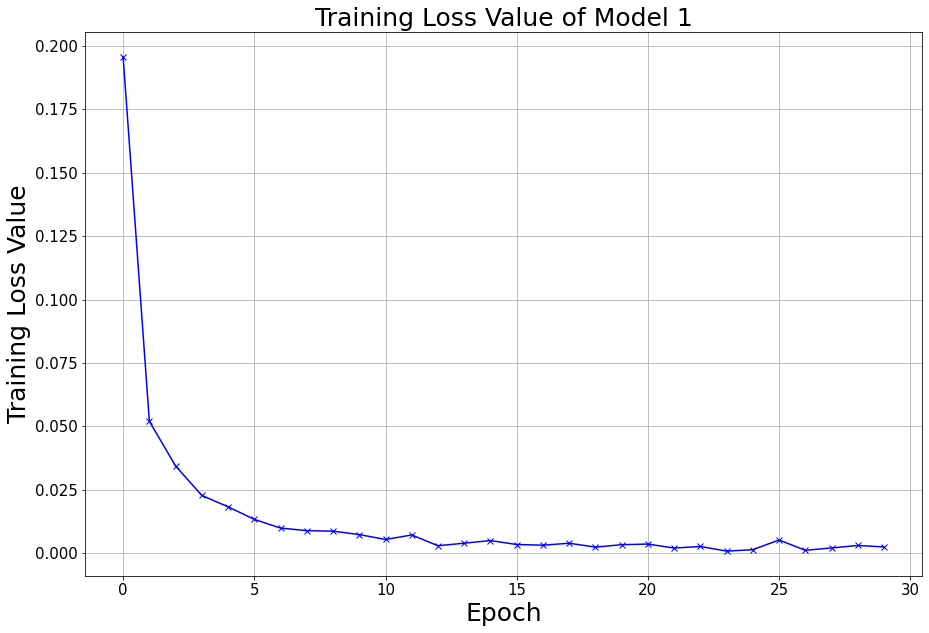

In [15]:
graph(model1_cost, "Training Loss Value of Model 1", yaxis_title="Training Loss Value")

## Model2 Loss/Epoch Graph

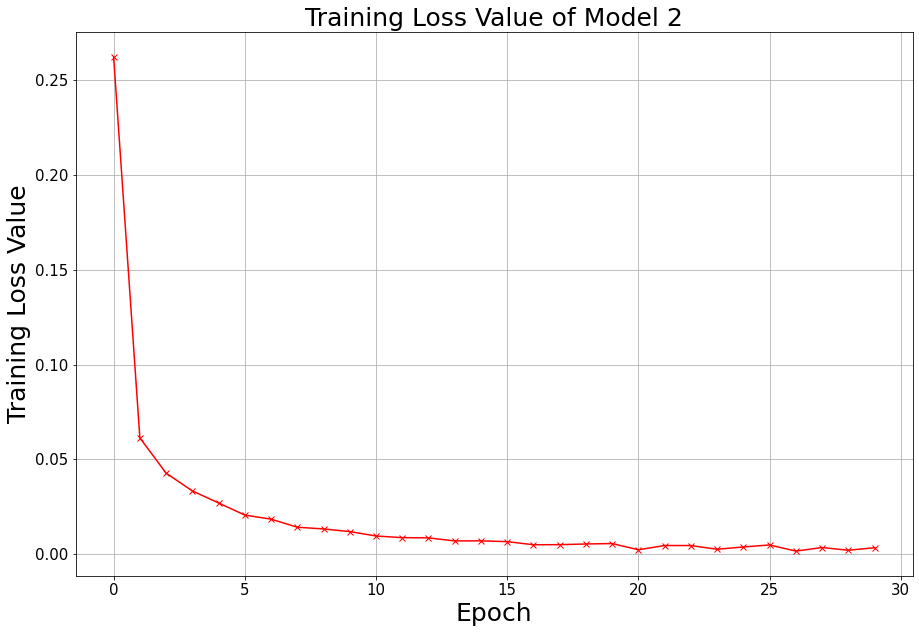

In [16]:
graph(model2_cost, "Training Loss Value of Model 2", yaxis_title="Training Loss Value", plot_color_type="r")

## Model3 Loss/Epoch Graph

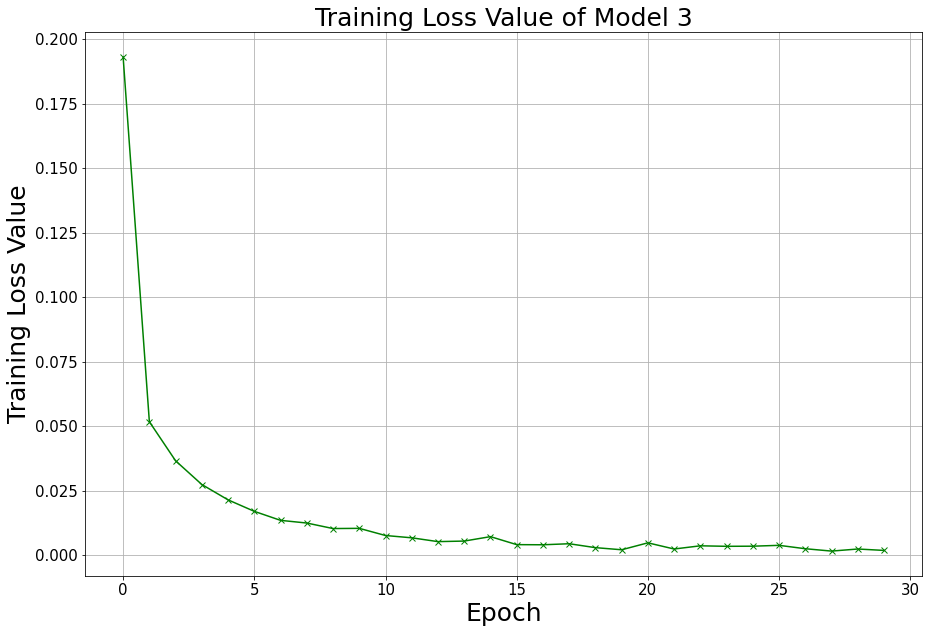

In [17]:
graph(model3_cost, "Training Loss Value of Model 3", yaxis_title="Training Loss Value", plot_color_type="g")

## Combine Model 1, 2, 3 Graphs

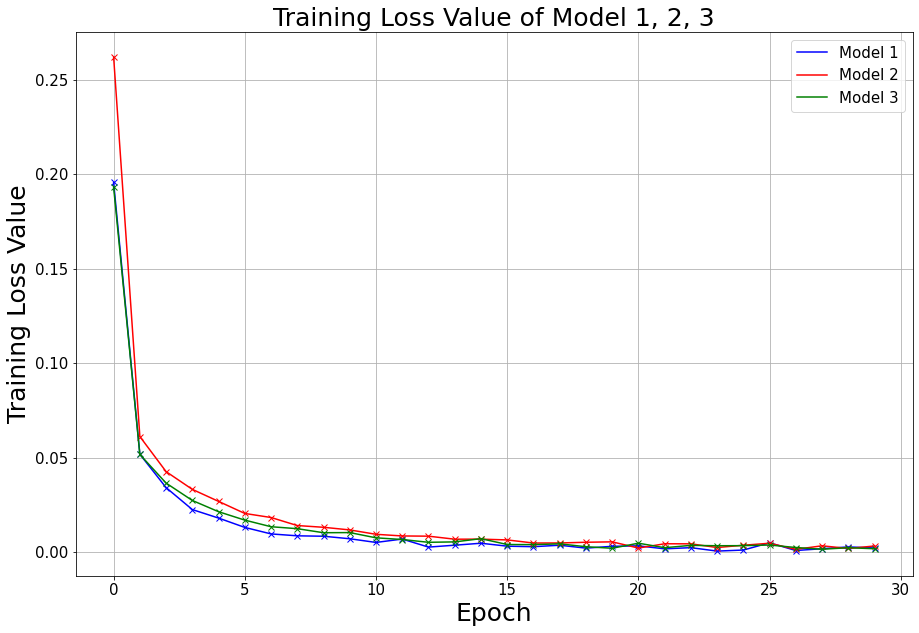

In [18]:
plt.figure(figsize=(15, 10), facecolor="white")
plt.title("Training Loss Value of Model 1, 2, 3", fontdict = {'fontsize' : 25})
plt.xlabel("Epoch", fontdict = {'fontsize' : 25})
plt.ylabel("Training Loss Value", fontdict = {'fontsize' : 25})

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.plot(list(range(30)), model1_cost, "bx")
plt.plot(list(range(30)), model1_cost, "b", label="Model 1")

plt.plot(list(range(30)), model2_cost, "rx")
plt.plot(list(range(30)), model2_cost, "r", label="Model 2")

plt.plot(list(range(30)), model3_cost, "gx")
plt.plot(list(range(30)), model3_cost, "g", label="Model 3")

plt.legend(fontsize=15)

# Accuracy of Model1, Model2 and Model3

## Model1 Accuracy/Epoch Graph

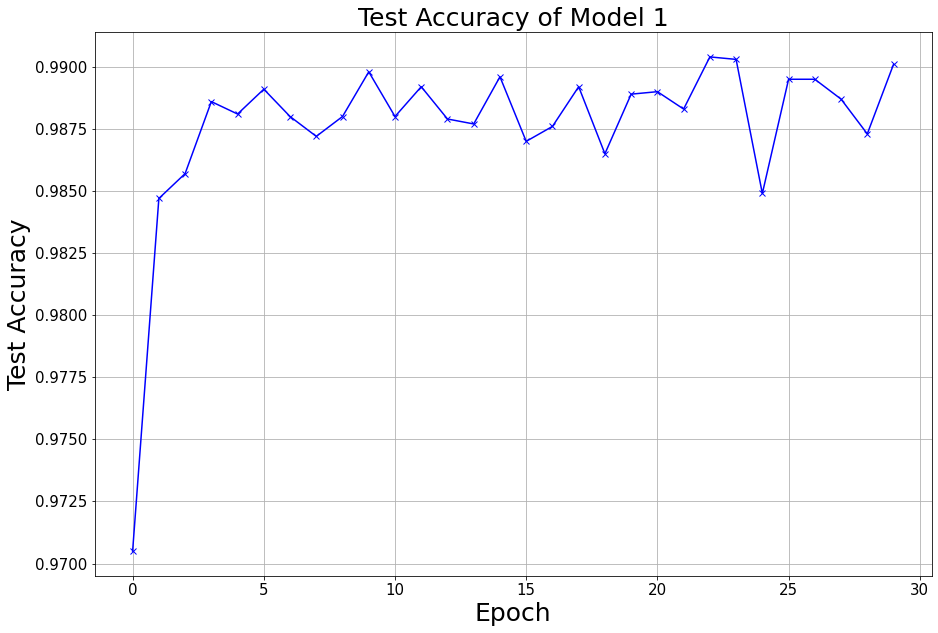

In [19]:
graph(model1_acc, "Test Accuracy of Model 1", yaxis_title="Test Accuracy")

## Model2 Accuracy/Epoch Graph

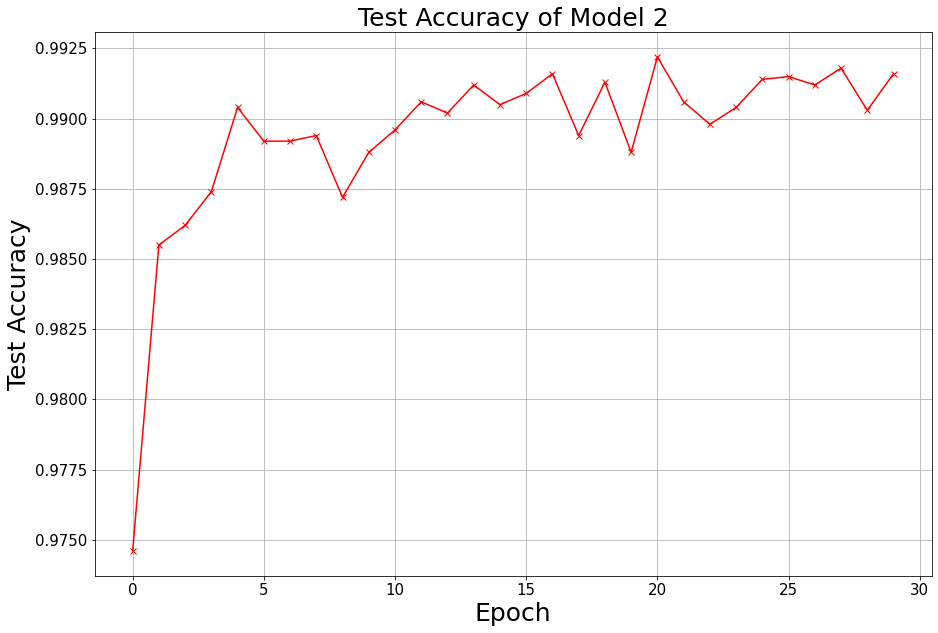

In [20]:
graph(model2_acc, "Test Accuracy of Model 2", yaxis_title="Test Accuracy", plot_color_type="r")

## Model3 Accuracy/Epoch Graph

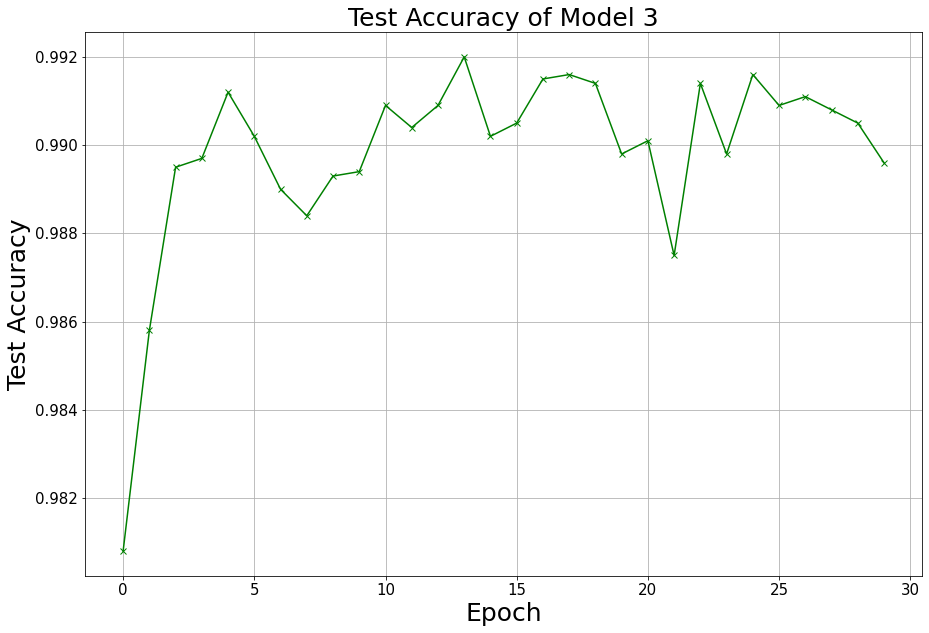

In [21]:
graph(model3_acc, "Test Accuracy of Model 3", yaxis_title="Test Accuracy", plot_color_type="g")

## Combine Model 1, 2, 3 Graphs

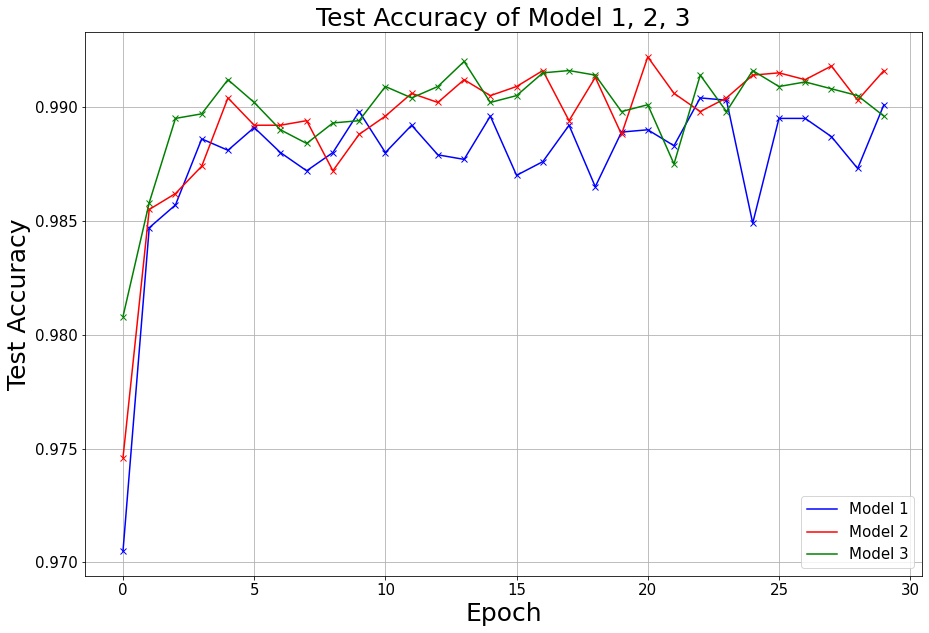

In [22]:
plt.figure(figsize=(15, 10), facecolor="white")
plt.title("Test Accuracy of Model 1, 2, 3", fontdict = {'fontsize' : 25})
plt.xlabel("Epoch", fontdict = {'fontsize' : 25})
plt.ylabel("Test Accuracy", fontdict = {'fontsize' : 25})

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.plot(list(range(30)), model1_acc, "bx")
plt.plot(list(range(30)), model1_acc, "b", label="Model 1")

plt.plot(list(range(30)), model2_acc, "rx")
plt.plot(list(range(30)), model2_acc, "r", label="Model 2")

plt.plot(list(range(30)), model3_acc, "gx")
plt.plot(list(range(30)), model3_acc, "g", label="Model 3")

plt.legend(fontsize=15)

# Evaluation Table

In [23]:
model1_final_training_loss = model1_cost[-1]
model2_final_training_loss = model2_cost[-1]
model3_final_training_loss = model3_cost[-1]

model1_final_test_acc = model1_acc[-1] * 100.0
model2_final_test_acc = model2_acc[-1] * 100.0
model3_final_test_acc = model3_acc[-1] * 100.0

In [24]:
final_training_loss = [model1_final_training_loss, model2_final_training_loss, model3_final_training_loss]
final_test_acc = [str(model1_final_test_acc) + "%", str(model2_final_test_acc) + "%", str(model3_final_test_acc) + "%"]

In [25]:
eval_table = pd.DataFrame(index=["Model1", "Model2", "Model3"], data={"Final Training Loss": final_training_loss, "Final Test Accuracy": final_test_acc})

In [26]:
display(eval_table)

,Final Training Loss,Final Test Accuracy
Model1,0.002367,99.00999999999999%
Model2,0.003420,99.16%
Model3,0.001957,98.96000000000001%


# Save Model

In [27]:
torch.save(best_model1, "./model1.pt")
torch.save(best_model2, "./model2.pt")
torch.save(best_model3, "./model3.pt")

## Load & Test Model

In [28]:
# Load Model1 & Test
test_model = CustomCNNModel1().to(device)
test_model.load_state_dict(torch.load("./model1.pt"))

test_model.eval()
correct = 0
with torch.no_grad() :
    for x, y in test_dloader :
        x = x.to(device)
        y = y.to(device)
        output = test_model(x)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

acc =  float(correct) / len(test_dloader.dataset)
print("Model 1 ACCURACY : ", acc * 100.0)

# Load Model2 & Test
test_model = CustomCNNModel2().to(device)
test_model.load_state_dict(torch.load("./model2.pt"))

test_model.eval()
correct = 0
with torch.no_grad() :
    for x, y in test_dloader :
        x = x.to(device)
        y = y.to(device)
        output = test_model(x)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

acc =  float(correct) / len(test_dloader.dataset)
print("Model 2 ACCURACY : ", acc * 100.0)

# Load Model3 & Test
test_model = CustomCNNModel3().to(device)
test_model.load_state_dict(torch.load("./model3.pt"))

test_model.eval()
correct = 0
with torch.no_grad() :
    for x, y in test_dloader :
        x = x.to(device)
        y = y.to(device)
        output = test_model(x)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

acc =  float(correct) / len(test_dloader.dataset)
print("Model 3 ACCURACY : ", acc * 100.0)

Model 1 ACCURACY :  99.03999999999999
Model 2 ACCURACY :  99.22
Model 3 ACCURACY :  99.2
